In [33]:
import requests
import seaborn as sns
import pandas as pd
import time
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, ExtraTreesClassifier

In [2]:
with open('../data/pickledcooking.pkl','rb') as x:
    df_cook = pickle.load(x)

In [3]:
with open('../data/pickledbeginners.pkl','rb') as x:
    df_cforb = pickle.load(x)

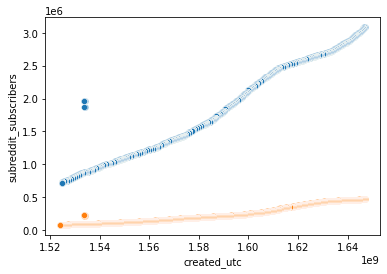

In [5]:
sns.scatterplot(data=df_cook,x='created_utc',y='subreddit_subscribers')
sns.scatterplot(data=df_cforb,x='created_utc',y='subreddit_subscribers');

In [9]:
df_cforb['domain'].value_counts(normalize=True)

self.cookingforbeginners    0.786821
i.redd.it                   0.067325
youtu.be                    0.060546
youtube.com                 0.041594
imgur.com                   0.002951
                              ...   
megadealerships.com         0.000046
campbells.com               0.000046
questionocean.com           0.000046
bnnbloomberg.ca             0.000046
simmyideas.com              0.000046
Name: domain, Length: 371, dtype: float64

In [10]:
df_cook['domain'].value_counts(normalize=True)

self.Cooking                0.994184
rg4amia.wordpress.com       0.000785
self.AskCulinary            0.000692
self.limitlessallergies     0.000415
self.cookingforbeginners    0.000185
                              ...   
self.suggestmearecipe       0.000046
self.PressureCooking        0.000046
self.KitchenConfidential    0.000046
self.sushi                  0.000046
self.Frugal                 0.000046
Name: domain, Length: 70, dtype: float64

Right now, all of this information is for testing some things. It's interesting that r/cooking has had more robust growth, even relative to its size when compared to r/cookingforbeginners. Along with this, they have or recently put in place a rule of only allowing self-posts (it's implausible that 99.4% of posts would be selfs otherwise, especially when an informal look at reddit suggests that image/video posts tend to do better. Also, there are some cross-posts like suggestmearecipe or kitchenconfidential)

In [16]:
df_cook.columns

Index(['created_utc', 'domain', 'selftext', 'subreddit_subscribers', 'title'], dtype='object')

In [17]:
df_cook['selftext'].value_counts(normalize=True)

[removed]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          0.154308
                                                                                                                                                                                                                                                                                                                                                                                            

In [19]:
df_cforb['selftext'].value_counts(normalize=True)

15.4% removed (by mods/admins) on cooking versus 22.7% on CforB, and 6.85% removed by creator on cooking versus14.8% on CforB. These are all interesting ideas. Let's try to focus on only self-text (or at least primarily so) in this notebook. Figuring out how to integrate for instance, the title in a vectorized way should be interesting, along with all the other features we dragged along and comments, but those also take extra effort in processing. Let's stick to just selftext for now

In [23]:
df_cook.isnull().sum(), df_cforb.isnull().sum()

(created_utc               0
 domain                    0
 selftext                 32
 subreddit_subscribers     0
 title                     0
 dtype: int64,
 created_utc               0
 domain                    0
 selftext                 60
 subreddit_subscribers     0
 title                     0
 dtype: int64)

While we have nulls, that too can be information on the class. We won't remove them, or if need be, we'll fill them with ''

The one thing we need is a class marker so that we can actually work with these

In [24]:
df_cook['sub'] = 'r/Cooking'

In [26]:
df_cforb['sub'] = 'r/Cookingforbeginners'

In [28]:
textdata = pd.concat([df_cook[['selftext','sub']],df_cforb[['selftext','sub']]])

In [29]:
X = textdata['selftext']
y = textdata['sub']

In [38]:
X.fillna('',inplace=True)

In [34]:
y.value_counts(normalize=True)

r/Cookingforbeginners    0.500254
r/Cooking                0.499746
Name: sub, dtype: float64

Null Model- about as even as you can get!

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=815,stratify=y)

In [40]:
pipe1 = Pipeline([
    ('cv',CountVectorizer(strip_accents='unicode',ngram_range=(1,1),max_features=None)),
    ('logreg',LogisticRegression(penalty='l2'))#just calling some of these so you keep them in mind
])

In [41]:
pipe1.fit(X_train,y_train)
pipe1.score(X_test,y_test)

C:\Users\Karthik\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6164421479977855

So one of our simplest models got a score of 61.6%-we'll want to look more carefully into all our options, but this is at least a starting point